# Urban Nightscapes: An analysis of San Antonio, Texas using ISS photographs

In [25]:
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
import numpy as np
import numpy.ma as ma
import numpy.random
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
from pprint import pprint as pp

In [26]:
# Read image data using rasterio
impervious_data = "data/impervious.tif"
ntl_data = "data/ntl770.img"

impervious = rasterio.open(impervious_data)
ntl = rasterio.open(ntl_data)

print(f"The number of bands in {impervious.name} is {impervious.count}.")
print(f"The width (or number of columns) of the image is: {impervious.width}.")
print(f"The height (or number of rows) the image is {impervious.height}.")
print(impervious.shape)
print(impervious.bounds)
print(f"The upper-left coordinate is {impervious.transform * (0, 0)}.")
print()
print(f"The number of bands in {ntl.name} is {ntl.count}.")
print(f"The width (or number of columns) of the image is: {ntl.width}.")
print(f"The height (or number of rows) the image is {ntl.height}.")
print(ntl.shape)
print(ntl.bounds)
print(f"The upper-left coordinate is {ntl.transform * (0, 0)}.")

The number of bands in data/impervious.tif is 1.
The width (or number of columns) of the image is: 1447.
The height (or number of rows) the image is 1350.
(1350, 1447)
BoundingBox(left=2060800.9440954728, bottom=13634561.991441127, right=2203175.170243818, top=13767392.126410212)
The upper-left coordinate is (2060800.9440954728, 13767392.126410212).

The number of bands in data/ntl770.img is 1.
The width (or number of columns) of the image is: 1447.
The height (or number of rows) the image is 1350.
(1350, 1447)
BoundingBox(left=2060800.9440954728, bottom=13634561.991441127, right=2203175.170243818, top=13767392.126410212)
The upper-left coordinate is (2060800.9440954728, 13767392.126410212).


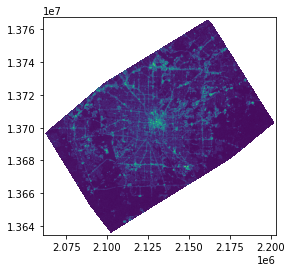

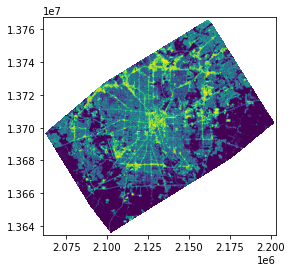

<AxesSubplot:>

In [27]:
show(ntl)
show(impervious)

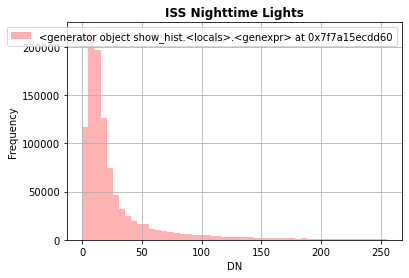

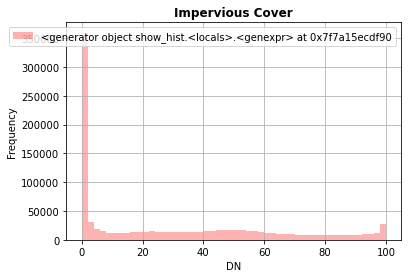

In [28]:
show_hist(ntl, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="ISS Nighttime Lights")
show_hist(impervious, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Impervious Cover")

In [29]:
y = ma.masked_greater(impervious.read(1), 500)
print(y.shape)
# y = y[impervious.width // 2 - 5: impervious.width // 2 + 5, impervious.height // 2 - 5: impervious.height // 2 + 5]
# print(y.shape)
y = y[y.mask == False]
print(y.shape)
x = ma.masked_greater(ntl.read(1), 500)
print(x.shape)
# x = x[impervious.width // 2 - 5: impervious.width // 2 + 5, impervious.height // 2 - 5: impervious.height // 2 + 5]
# print(x.shape)
x = x[x.mask == False]
print(x.shape)

(1350, 1447)
(1009069,)
(1350, 1447)
(1009069,)


In [30]:
# y = y[impervious.width // 2 - 5: impervious.width // 2 + 5, impervious.height // 2 - 5: impervious.height // 2 + 5]
# x = x[impervious.width // 2 - 5: impervious.width // 2 + 5, impervious.height // 2 - 5: impervious.height // 2 + 5]

In [31]:
print(f"The min/max values for 'y'  are {y.min()} and {y.max()}, respectively.")
print(y)
print(y.shape)
print()
print(f"The min/max values for 'x' (nighttime lights) are {x.min()} and {x.max()}, respectively.")
print(x)
print(x.shape)

The min/max values for 'y'  are 0 and 100, respectively.
[51 84 91 ... 0 0 0]
(1009069,)

The min/max values for 'x' (nighttime lights) are 0 and 255, respectively.
[7 11 27 ... 11 20 15]
(1009069,)


(array([389486.,  27589.,  19832.,  24452.,  19009.,  20774.,  28871.,
         21208.,  21371.,  27583.,  20543.,  20948.,  30919.,  25568.,
         26358.,  34235.,  23459.,  20981.,  24160.,  15577.,  14209.,
         17797.,  12759.,  11907.,  15825.,  12351.,  12964.,  18779.,
         16101.,  33454.]),
 array([  0.        ,   3.33333333,   6.66666667,  10.        ,
         13.33333333,  16.66666667,  20.        ,  23.33333333,
         26.66666667,  30.        ,  33.33333333,  36.66666667,
         40.        ,  43.33333333,  46.66666667,  50.        ,
         53.33333333,  56.66666667,  60.        ,  63.33333333,
         66.66666667,  70.        ,  73.33333333,  76.66666667,
         80.        ,  83.33333333,  86.66666667,  90.        ,
         93.33333333,  96.66666667, 100.        ]),
 <BarContainer object of 30 artists>)

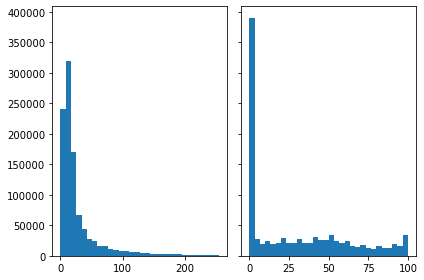

In [32]:
# x_bins, y_bins = x.size // 10, y.size // 10
x_bins, y_bins = 30, 30
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(x, bins=x_bins)
axs[1].hist(y, bins=y_bins)

In [33]:
# Necessary to calculate a y-intercept
# Comment out if regression through origin is desired
X = sm.add_constant(x, prepend=False)

## OLS Regression

In [34]:
mod = sm.OLS(y, X)
results = mod.fit()
print(results.summary())

OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                 2.897e+05
Date:                Mon, 25 Jan 2021   Prob (F-statistic):               0.00
Time:                        16:33:08   Log-Likelihood:            -4.7970e+06
No. Observations:             1009069   AIC:                         9.594e+06
Df Residuals:                 1009067   BIC:                         9.594e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4023      0.001    538.220      0.000       0.401       0.404
c

## OLS Regression with log(ISS)

In [54]:
logx = np.log(x)
logX = sm.add_constant(logx, prepend=False)
log_mod = sm.OLS(y, logX)
log_results = log_mod.fit()
print(log_results.summary())

OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                 3.063e+05
Date:                Mon, 25 Jan 2021   Prob (F-statistic):               0.00
Time:                        18:42:31   Log-Likelihood:            -1.7181e+06
No. Observations:             1009069   AIC:                         3.436e+06
Df Residuals:                 1009067   BIC:                         3.436e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7358      0.001    553.440      0.000       0.733       0.738
c

## Polynomial Regression

In [51]:
# polynomial fit
degree = 4

weights = np.polyfit(x, y, degree)
print(f"The weight coefficient are: {weights}\n")
model = np.poly1d(weights)
print(f"The full polynomial equation is: \n{model}.\n")
df = pd.DataFrame(columns=['y', 'x'])
df['x'] = x
df['y'] = y
polyresults = smf.ols(formula='y ~ model(x)', data=df).fit()
print(polyresults.summary())
# end polynomial fit

plyres = polyresults.fittedvalues.to_numpy()



The weight coefficient are: [-1.21132129e-07  7.57416329e-05 -1.68941599e-02  1.67237062e+00
  3.55821968e+00]

The full polynomial equation is: 
            4             3           2
-1.211e-07 x + 7.574e-05 x - 0.01689 x + 1.672 x + 3.558.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                 4.303e+05
Date:                Mon, 25 Jan 2021   Prob (F-statistic):               0.00
Time:                        18:36:58   Log-Likelihood:            -4.7451e+06
No. Observations:             1009069   AIC:                         9.490e+06
Df Residuals:                 1009067   BIC:                         9.490e+06
Df Model:                           1                                         
Covariance Type:            nonrobust       

## Feature Space Image generation

In [35]:
heatmap, xedges, yedges = np.histogram2d(x, y, bins=(128, 50))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
heatmap[heatmap == 0] = np.NaN

<Figure size 432x288 with 0 Axes>

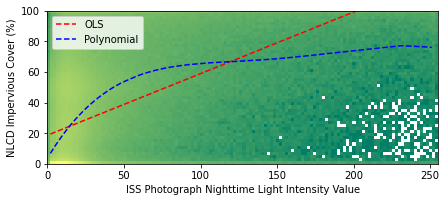

In [50]:
plt.clf()
plt.figure(figsize=(7, 3))

# Plot headmap
plt.imshow(heatmap.T, cmap='summer', norm=mpl.colors.SymLogNorm(2), extent=extent, origin='lower')

# plt.plot(x, results.fittedvalues, 'r--.', label="OLS") # DON'T DO WITH LARGE ARRAY!
# If the line above is commented out, do this instead...this is the best sub-selector
get_every_nth = 99
ols_x = x[0::len(x)//get_every_nth]
ols_y = results.fittedvalues[0::len(results.fittedvalues)//get_every_nth]
poly_y = plyres[0::len(plyr)//get_every_nth]
log_y = 

df_ols = pd.DataFrame(columns=['y', 'x'])
df_ols['x'] = ols_x
df_ols['y'] = ols_y
df_ols = df_ols.sort_values(by=['x'])

df_poly = pd.DataFrame(columns=['y', 'x'])
df_poly['x'] = ols_x
df_poly['y'] = poly_y
df_poly = df_poly.sort_values(by=['x'])

df_log = pd.DataFrame(columns=['y', 'x'])
df_log['x'] = ols_x
# df_log['y'] = np.log()

plt.plot(df_ols['x'], df_ols['y'], 'r--', label="OLS")
plt.plot(df_poly['x'], df_poly['y'], 'b--', label="Polynomial")
# ...end here.

plt.ylim([0, 100])
plt.xlabel("ISS Photograph Nighttime Light Intensity Value")
plt.ylabel("NLCD Impervious Cover (%)")
plt.legend(loc='best')

plt.show()


### Done for now....

In [38]:
4%3

1